In [46]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA

In [47]:
# Hot coding and drop no necessary columns
def preprocess_data(data):
    data = pd.concat([data, pd.get_dummies(data['Education_Level']).drop(columns=['Unknown'])], axis=1)
    data = pd.concat([data, pd.get_dummies(data['Income_Category']).drop(columns=['Unknown'])], axis=1)
    data = pd.concat([data, pd.get_dummies(data['Marital_Status']).drop(columns=['Unknown'])], axis=1)
    data = pd.concat([data, pd.get_dummies(data['Card_Category']).drop(columns=['Platinum'])], axis=1)
    
    data.drop(columns=['Education_Level', 'Income_Category', 'Marital_Status', 'Card_Category', 'CLIENTNUM'], inplace=True)
    
    return data

In [48]:
data = pd.read_csv('../data/Bank_All.csv')
data = data[data.columns[:-2]]

data.Attrition_Flag = data.Attrition_Flag.replace({'Attrited Customer':1,'Existing Customer':0})
data.Gender = data.Gender.replace({'F':1,'M':0})


age_40 = data[data['Customer_Age'] < 40]
age_40_to_50 = data[(data['Customer_Age'] >= 40) & (data['Customer_Age'] <= 50)]
age_50 = data[data['Customer_Age'] > 50]

age_40.to_csv('../data/Bank1.csv', index=False)
age_40_to_50.to_csv('../data/Bank2.csv', index=False)
age_50.to_csv('../data/Bank3.csv', index=False)

# Read the data from CSV files
data1 = pd.read_csv('../data/Bank1.csv')
data2 = pd.read_csv('../data/Bank2.csv')
data3 = pd.read_csv('../data/Bank3.csv')

# Randomly sample 20% of each dataset
sample1 = data1.sample(frac=0.3, random_state=42)
sample2 = data2.sample(frac=0.3, random_state=42)
sample3 = data3.sample(frac=0.3, random_state=42)

# Combine the samples into a single DataFrame
new_data = pd.concat([sample1, sample2, sample3], ignore_index=True)

new_data = preprocess_data(new_data)

<AxesSubplot: >

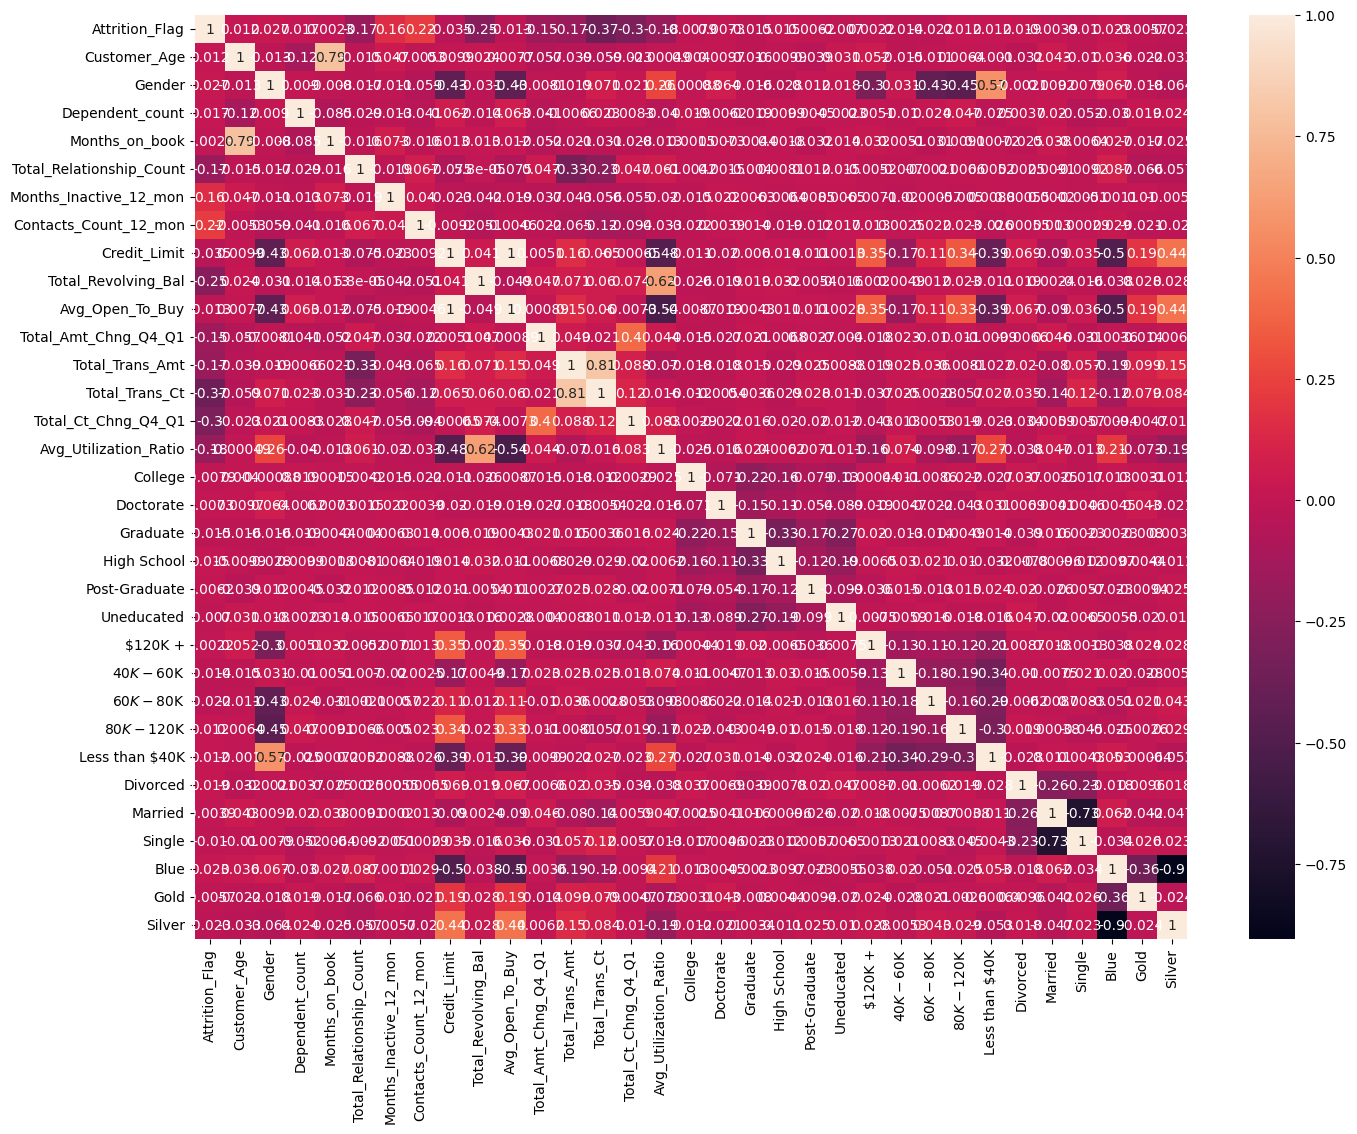

In [49]:
plt.figure(figsize=(16, 12))
sns.heatmap(new_data.corr('pearson'), annot=True, annot_kws={'size': 10})

<AxesSubplot: >

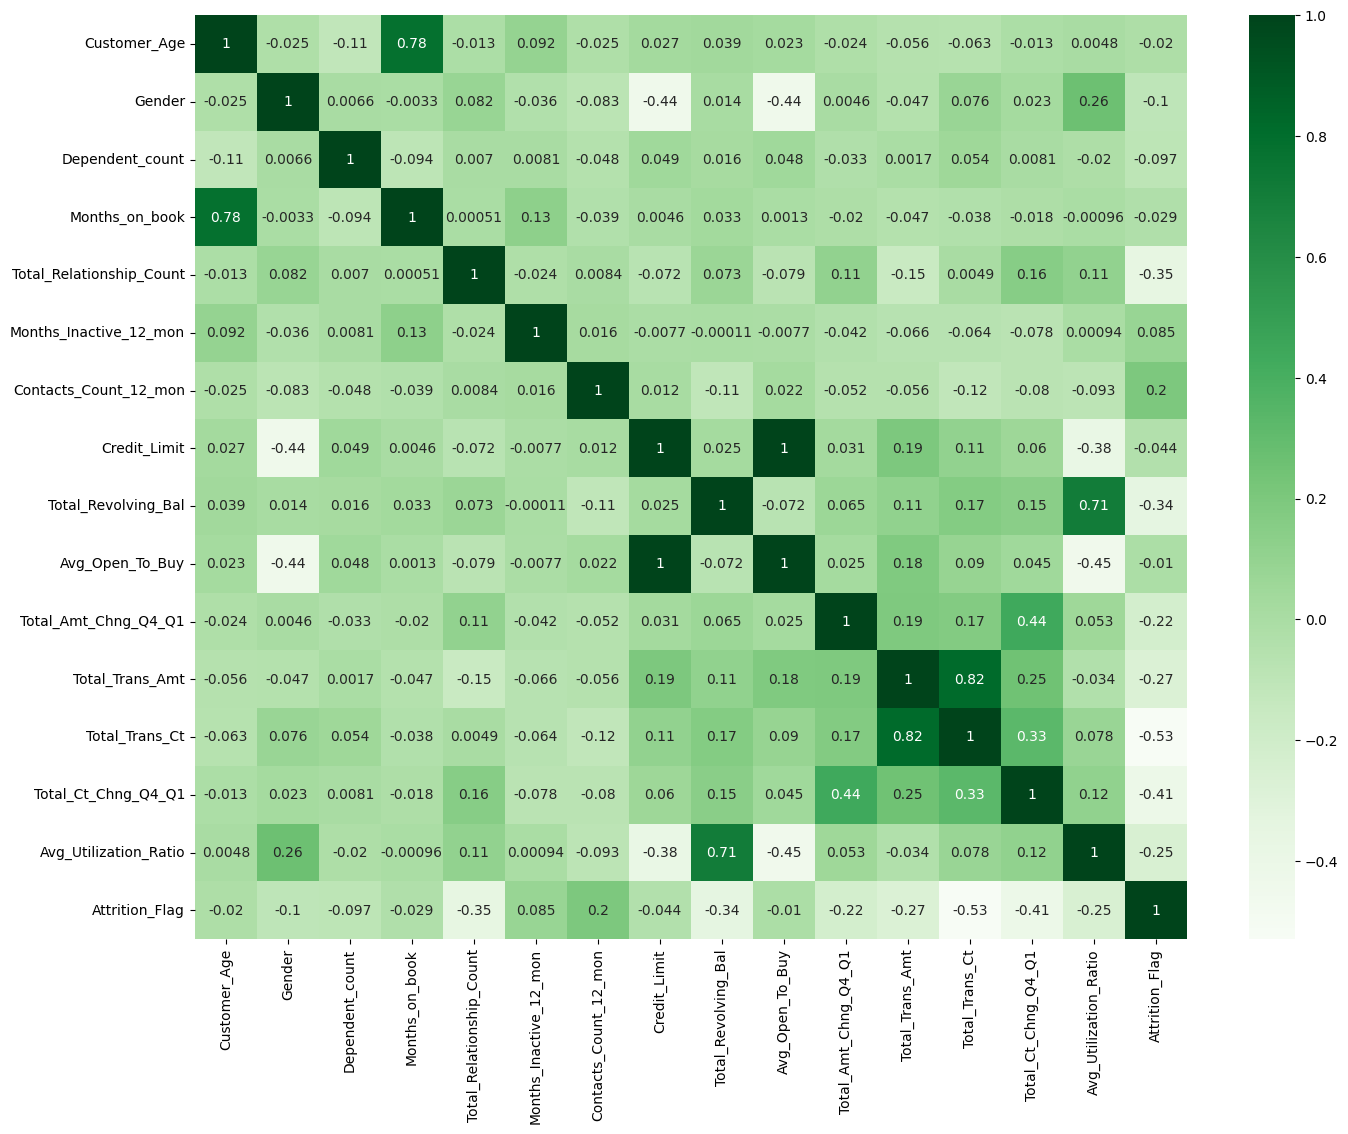

In [50]:
# Oversample the dataset using SMOTE to balance the target variable and features
oversample = SMOTE()
# X: variables, y: target
X, y = oversample.fit_resample(new_data[new_data.columns[1:]], new_data[new_data.columns[0]])
usampled_df = X.assign(Attrition_Flag = y) #

# Copy the hot code variables, delte them from usampled_df
ohe_data =usampled_df[usampled_df.columns[15:-1]].copy() 

# Remove the categorical features after One-Hot Encoding, delete usampled_df.columns[15:-1]
usampled_df = usampled_df.drop(columns=usampled_df.columns[15:-1])

# The heat map only shows the relationship between numerical features
plt.figure(figsize=(16, 12))
sns.heatmap(usampled_df.corr('pearson'), annot=True, annot_kws={'size': 10}, cmap="Greens")

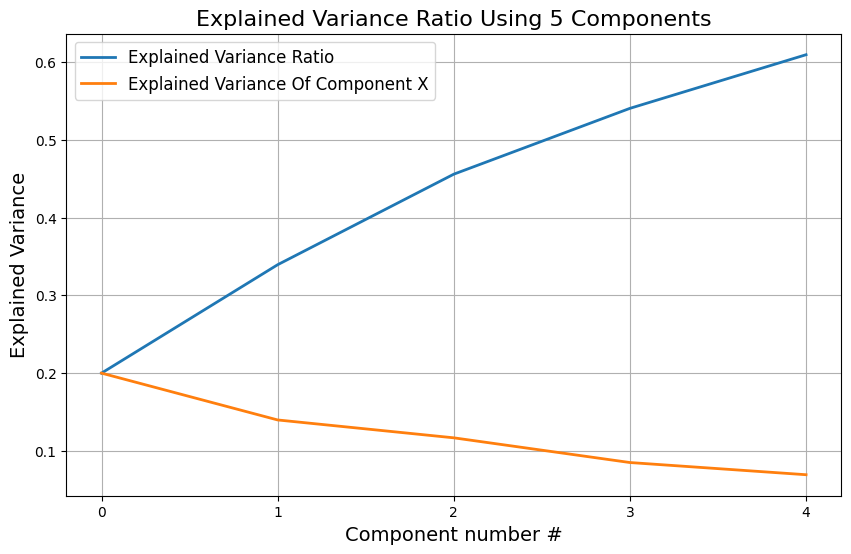

In [51]:
N_COMPONENTS = 5

# PCA
pca_model = PCA(n_components=N_COMPONENTS)
# Apply PCA model for dimensionality reduction
pc_matrix = pca_model.fit_transform(ohe_data)

# The proportion of variance explained by each principal component to the total variance
evr = pca_model.explained_variance_ratio_
# The sum
cumsum_evr = np.cumsum(evr)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))
# Plot the explained variance ratio
sns.lineplot(x=np.arange(0, len(cumsum_evr)), y=cumsum_evr, label='Explained Variance Ratio', linewidth=2, ax=ax)
# Plot the explained variance of component X
sns.lineplot(x=np.arange(0, len(cumsum_evr)), y=evr, label='Explained Variance Of Component X', linewidth=2, ax=ax)

ax.set_xticks([i for i in range(0, len(cumsum_evr))])
# Set x and y axis labels
ax.set_xlabel('Component number #', fontsize=14)
ax.set_ylabel('Explained Variance', fontsize=14)

# Set the title
ax.set_title(f'Explained Variance Ratio Using {N_COMPONENTS} Components', fontsize=16)
ax.grid(True)
ax.legend(fontsize=12)
plt.show()

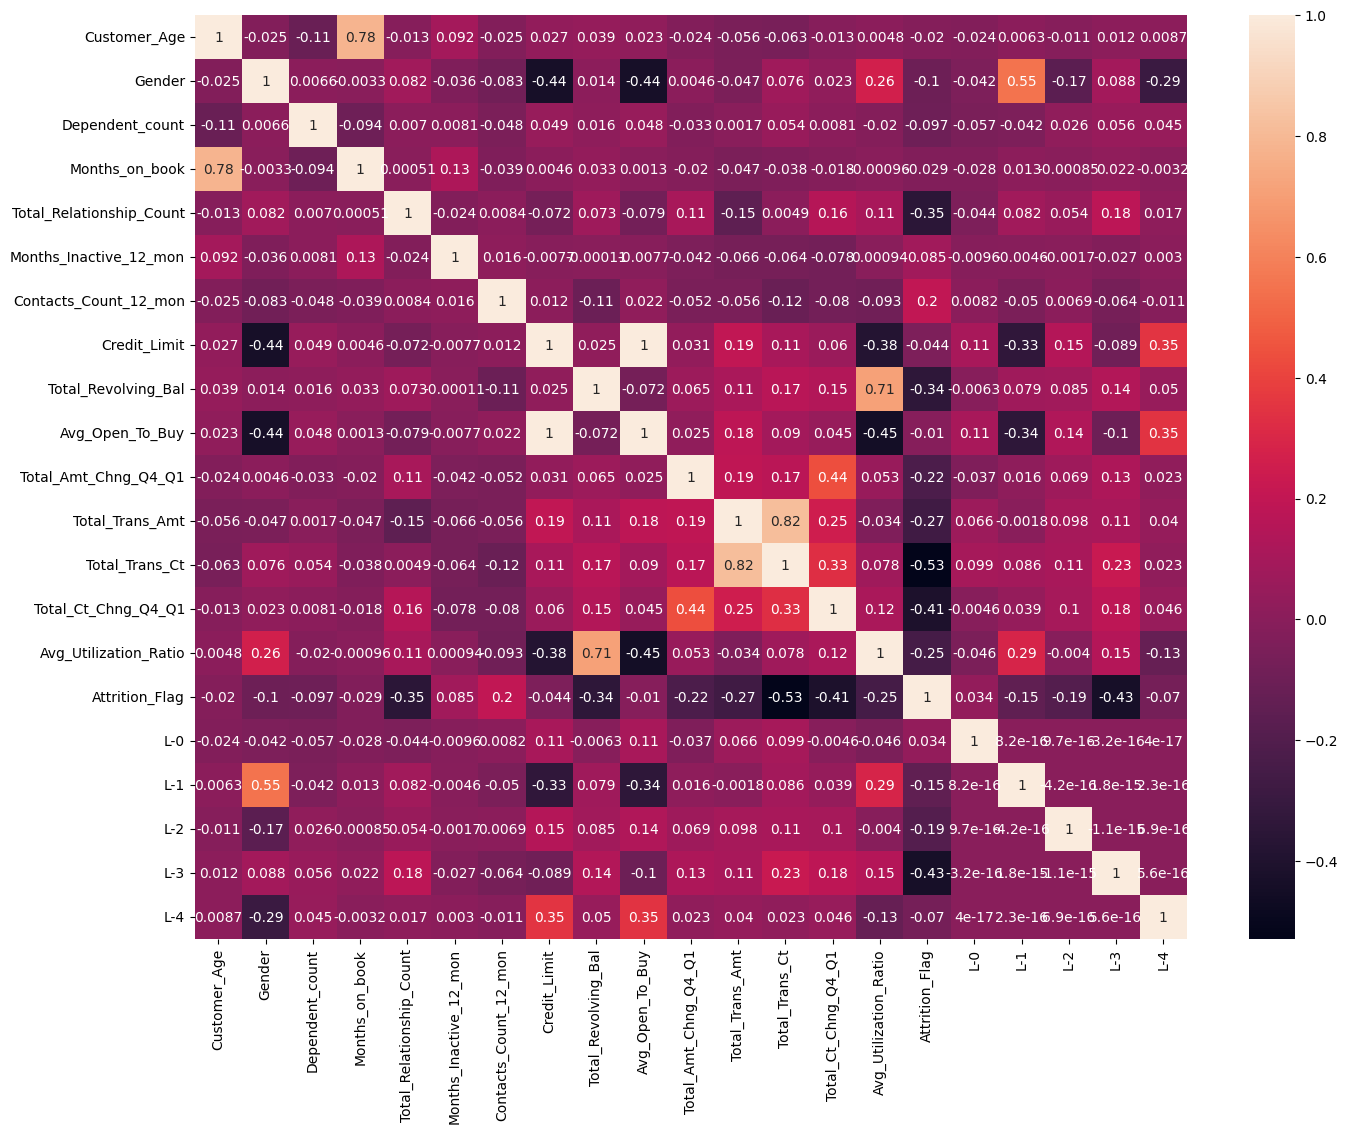

<AxesSubplot: >

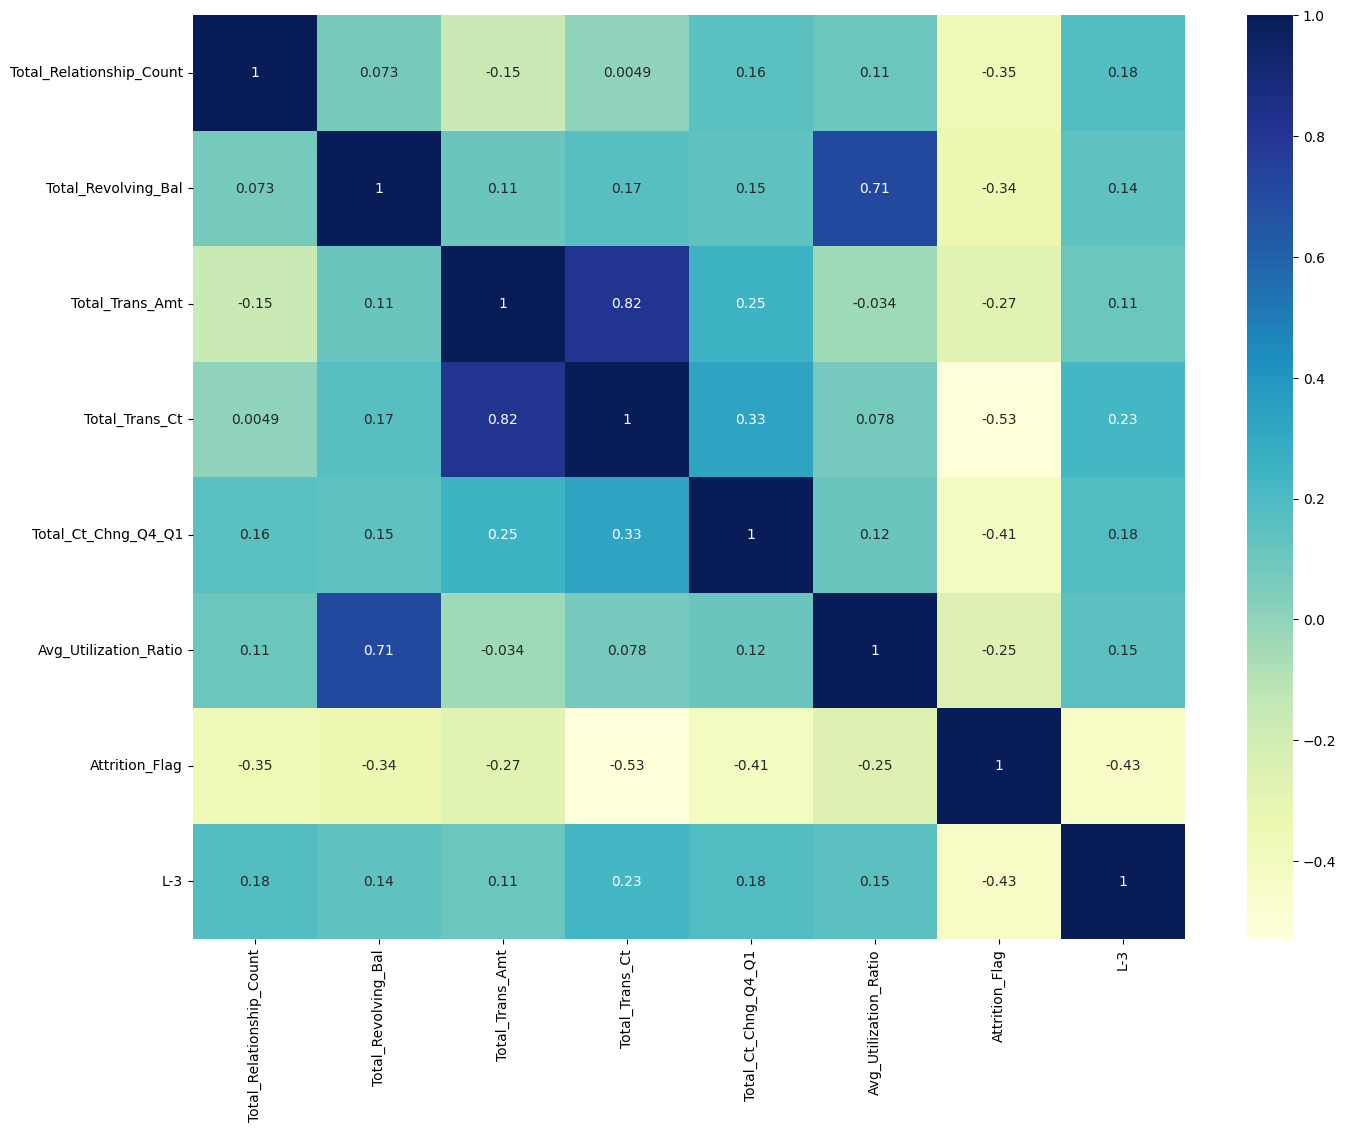

In [52]:
new_data = pd.concat([usampled_df,
                                  pd.DataFrame(pc_matrix,columns=['L-{}'.format(i) for i in range(0,N_COMPONENTS)])],
                                 axis=1)
plt.figure(figsize=(16, 12))
sns.heatmap(new_data.corr('pearson'), annot=True, annot_kws={'size': 10})
plt.show()

# Define the correlation threshold
t = 0.25

# Calculate the correlation matrix
corr_matrix = new_data.corr('pearson')

# Filter the variables with a correlation higher than the threshold
strong_correlations = corr_matrix[abs(corr_matrix['Attrition_Flag']) > t].index

# Create a subset of the correlation matrix containing only strongly correlated variables
filtered_corr_matrix = corr_matrix.loc[strong_correlations, strong_correlations]

# Create a heatmap with a blue-green color palette
plt.figure(figsize=(16, 12))
sns.heatmap(filtered_corr_matrix, annot=True, annot_kws={'size': 10}, cmap="YlGnBu")


In [53]:
def select_feature(data, pca_model, strong_features):
    ohe_data = data[data.columns[16:]].copy()
    pc_matrix = pca_model.transform(ohe_data)
    
    new_data = pd.concat([data, pd.DataFrame(pc_matrix, columns=['L-{}'.format(i) for i in range(0, len(pc_matrix[0]))])], axis=1)
    new_data = new_data[strong_features]
    new_data['Attrition_Flag'] = data['Attrition_Flag']
    
    return new_data

In [54]:
# Save the strongly correlated variables in Strong_Features list (excluding 'Attrition_Flag')
Strong_features = list(strong_correlations)
Strong_features.remove('Attrition_Flag')
print(Strong_features)

# Re-load the original data
data1 = pd.read_csv("../data/Bank1.csv")
data2 = pd.read_csv("../data/Bank2.csv")
data3 = pd.read_csv("../data/Bank3.csv")

data1 = preprocess_data(data1)
data2 = preprocess_data(data2)
data3 = preprocess_data(data3)

bank1 = select_feature(data1, pca_model, Strong_features)
bank2 = select_feature(data2, pca_model, Strong_features)
bank3 = select_feature(data3, pca_model, Strong_features)

# Save the new DataFrame as a CSV file
bank1.to_csv("../data/bank1_New.csv", index=False)
bank2.to_csv("../data/bank2_New.csv", index=False)
bank3.to_csv("../data/bank3_New.csv", index=False)

['Total_Relationship_Count', 'Total_Revolving_Bal', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio', 'L-3']
